In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import joblib

import sklearn
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

import skforecast
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.utils import load_forecaster

In [2]:
currency_df = pd.read_excel("exchange_hisroty_cbr.xlsx")

In [3]:
print(set(currency_df["Букв. код"].to_list()))

{'KRW', 'TRY', 'UZS', 'RSD', 'EUR', 'BEF', 'AUD', 'NLG', 'INR', 'NZD', 'ITL', 'GBP', 'BRL', 'HUF', 'IEP', 'FRF', 'BYR', 'ESP', 'BYN', 'IDR', 'SEK', 'TRL', 'MDL', 'PLN', 'CAD', 'ISK', 'PTE', 'CNY', 'XEU', 'BYB', 'KGS', 'NOK', 'JPY', 'LVL', 'AED', 'RON', 'EEK', 'LTL', 'GEL', 'BGN', 'CZK', 'QAR', 'KZT', 'HKD', 'UAH', 'GRD', 'TMT', 'THB', 'AMD', 'ATS', 'ZAR', 'DEM', 'SGD', 'VND', 'EGP', 'AZN', 'XDR', 'TJS', 'FIM', 'CHF', 'USD', 'DKK'}


In [4]:
data = currency_df[currency_df["Букв. код"] == "BRL"].reset_index()

In [5]:
data = data[["Курс", "Дата"]]
data = data.rename(columns={"Курс": "rate", "Дата": "date"})
data["date"] = pd.to_datetime(data["date"], format="%d.%m.%Y")
data = data.set_index("date").asfreq("D").sort_index()

In [6]:
data

,rate
date,
2010-01-12,17.0451
2010-01-13,16.9127
2010-01-14,16.9774
2010-01-15,16.7406
2010-01-16,16.8100
...,...
2024-07-12,16.3049
2024-07-13,16.2195
2024-07-14,16.2195


In [7]:
complete_date_range = pd.date_range(start=data.index.min(), end=data.index.max(), freq=data.index.freq)
is_index_complete = (data.index == complete_date_range).all()

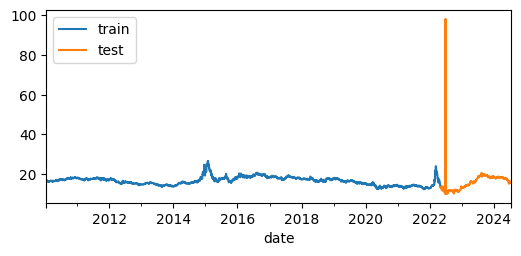

In [8]:
steps = 4500
data_train = data[:steps]
data_test  = data[steps:]

fig, ax = plt.subplots(figsize=(6, 2.5))
data_train["rate"].plot(ax=ax, label="train")
data_test["rate"].plot(ax=ax, label="test")
ax.legend();

In [71]:
forecaster = ForecasterAutoreg(
                 regressor = GradientBoostingRegressor(
                    loss = 'squared_error', 
                    learning_rate = 0.19, 
                    n_estimators = 100, 
                    subsample = 1, 
                    criterion = 'squared_error', 
                    min_samples_split = 2, 
                    min_samples_leaf = 1, 
                    min_weight_fraction_leaf = 0, 
                    max_depth = 3, 
                    min_impurity_decrease = 0.000001, 
                    random_state = 42, 
                    max_features = 0.5, 
                    verbose = 0, 
                    max_leaf_nodes = None, 
                    warm_start = True, 
                    n_iter_no_change = None,  
                    ccp_alpha = 0
                     
                 ),
                 lags = 3000
             )
forecaster.fit(y=data_train["rate"])
forecaster

ForecasterAutoreg 
Regressor: GradientBoostingRegressor(ccp_alpha=0, criterion='squared_error',
                          learning_rate=0.19, max_features=0.5,
                          min_impurity_decrease=1e-06,
                          min_weight_fraction_leaf=0, random_state=42,
                          subsample=1, warm_start=True) 
Lags: [   1    2    3 ... 2998 2999 3000] 
Transformer for y: None 
Transformer for exog: None 
Window size: 3000 
Weight function included: False 
Differentiation order: None 
Exogenous included: False 
Exogenous variables names: None 
Training range: [Timestamp('2010-01-12 00:00:00'), Timestamp('2022-05-08 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: D 
Regressor parameters: {'alpha': 0.9, 'ccp_alpha': 0, 'criterion': 'squared_error', 'init': None, 'learning_rate': 0.19, 'loss': 'squared_error', 'max_depth': 3, 'max_features': 0.5, 'max_leaf_nodes': None, 'min_impurity_decrease': 1e-06, 'min_samples_leaf': 1, 'min_sam

In [72]:
predictions = forecaster.predict(steps=len(data) - steps)

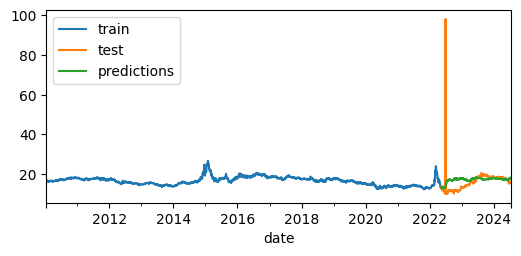

In [73]:
fig, ax = plt.subplots(figsize=(6, 2.5))
data_train["rate"].plot(ax=ax, label="train")
data_test["rate"].plot(ax=ax, label="test")
predictions.plot(ax=ax, label="predictions")
ax.legend();

In [74]:
print(mean_squared_error(data_test["rate"],predictions))

18.50361080042734


In [75]:
joblib.dump(forecaster, "BRL_fluctuation_forecaster.sav")

['BRL_fluctuation_forecaster.sav']